In [1]:
%%capture
%run full_setup.py

In [2]:
from tfidf_corpus_dictionary import get_tfidf_tokendocs_corpus_dict
from gensim.models import LdaModel, LsiModel, CoherenceModel
from sklearn.decomposition import NMF, PCA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import os

With this function we get various objects needed for modelling:
1. TFIDF matrix as input data, with specified parameters
2. feature names as the words retained with TFIDF
3. tokenized documents, a list of lists, where the inner lists contain the tokens for each document
4. corpus, gensim object needed for modelling with that package
4. dictionary, gensim object containing informations on the words of the corpus and their positions

In [3]:
tfidf_matrix, feature_names, tokenized_docs, corpus, dictionary = get_tfidf_tokendocs_corpus_dict(df, max_df=0.5, min_df=5, max_features=1000)

Now we'll evaluate different topic models based on Coherence score.

Coherence is a metric used to evalute topics quality. The higher the coherence, the better the model did in creating the topics.

For every model we'll use a function to retrieve coherence for different numbers of topics (5, 10, 15, 20, 50). This information will be used to evaluate how the models performed as the number of topics changes

In [4]:
from coherence_by_topics import coherence_by_topics
from coherence_by_words import coherence_by_words

In [5]:
topics = [5, 10, 20, 50]

In [6]:
evaluation_by_topics = {}

for n_topics in topics:
    metrics_words = coherence_by_topics(n = n_topics, corpus=corpus, dictionary=dictionary,
                               texts=tokenized_docs, feature_names=feature_names, tfidf=tfidf_matrix)
    
    evaluation_by_topics[n_topics] = metrics_words

In [7]:
evaluation_by_topics[5]

[('LDA', 0.5179),
 ('LSA', 0.5469),
 ('NMF', 0.6479),
 ('PCA', 0.5464),
 ('RP', 0.2019)]

In [8]:
evaluation_by_topics[10]

[('LDA', 0.5264),
 ('LSA', 0.4587),
 ('NMF', 0.6736),
 ('PCA', 0.4517),
 ('RP', 0.2012)]

In [9]:
evaluation_by_topics[20]

[('LDA', 0.3957),
 ('LSA', 0.382),
 ('NMF', 0.633),
 ('PCA', 0.3656),
 ('RP', 0.2071)]

In [10]:
evaluation_by_topics[50]

[('LDA', 0.3593),
 ('LSA', 0.3138),
 ('NMF', 0.5271),
 ('PCA', 0.3193),
 ('RP', 0.2112)]

In [11]:
words = [10, 100, 1000, 10000]

In [12]:
evaluation_by_words = {}

for n_words in words:
    metrics_words = coherence_by_words(df, n = n_words)
    evaluation_by_words[n_words] = metrics_words

In [13]:
evaluation_by_words[10]

[('LDA', 0.4661),
 ('LSA', 0.4661),
 ('NMF', 0.4661),
 ('PCA', 0.4661),
 ('RP', 0.4661)]

In [14]:
evaluation_by_words[100]

[('LDA', 0.4183),
 ('LSA', 0.3723),
 ('NMF', 0.4723),
 ('PCA', 0.387),
 ('RP', 0.3258)]

In [15]:
evaluation_by_words[1000]

[('LDA', 0.5179),
 ('LSA', 0.5469),
 ('NMF', 0.6479),
 ('PCA', 0.5464),
 ('RP', 0.2019)]

In [16]:
evaluation_by_words[10000]

[('LDA', 0.4755),
 ('LSA', 0.4596),
 ('NMF', 0.7112),
 ('PCA', 0.625),
 ('RP', 0.6706)]

In [17]:
def plots(evaluation, type: str):
    for n, metrics in evaluation.items():
        model_names, coherence_values = zip(*metrics)

        # Create a DataFrame for easy plotting with Seaborn
        data = {'Model': model_names, 'Coherence Value': coherence_values}
        df = pd.DataFrame(data)

        plt.figure(figsize=(8, 5))
        
        # Use Seaborn's barplot with the hue parameter
        sns.barplot(x='Model', y='Coherence Value', data=df, hue='Model', palette='viridis')
        
        plt.xlabel('Model')
        plt.ylabel('Coherence Value')
        plt.title(f'Coherence Evaluation for {n} Words')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        figures_folder = R'C:\Users\andre\OneDrive - Alma Mater Studiorum Università di Bologna\University\UniBo\Machine Learning\PR1.20\figures'
        save_path = os.path.join(figures_folder, f'coherence_evaluation_{n}_{type}')
        
        plt.savefig(save_path)
        plt.show()

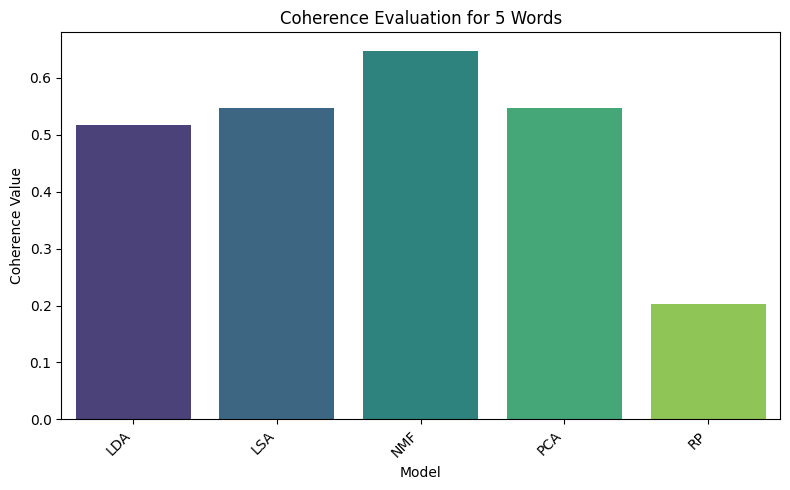

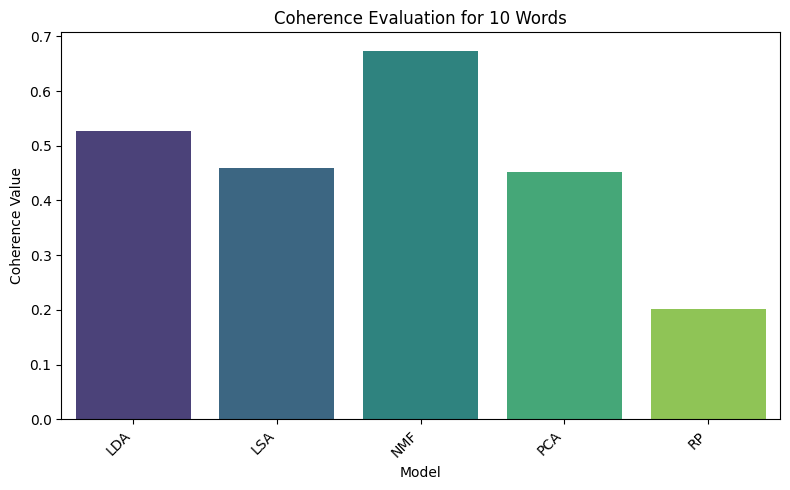

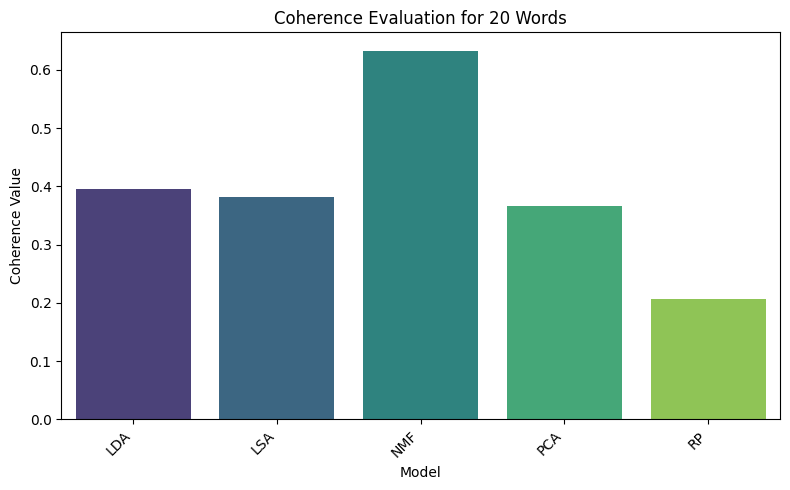

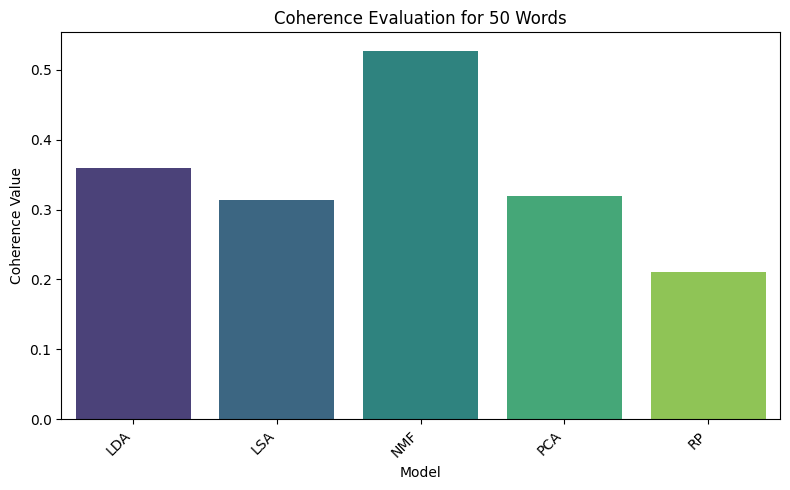

In [18]:
plots(evaluation_by_topics, 'topics')

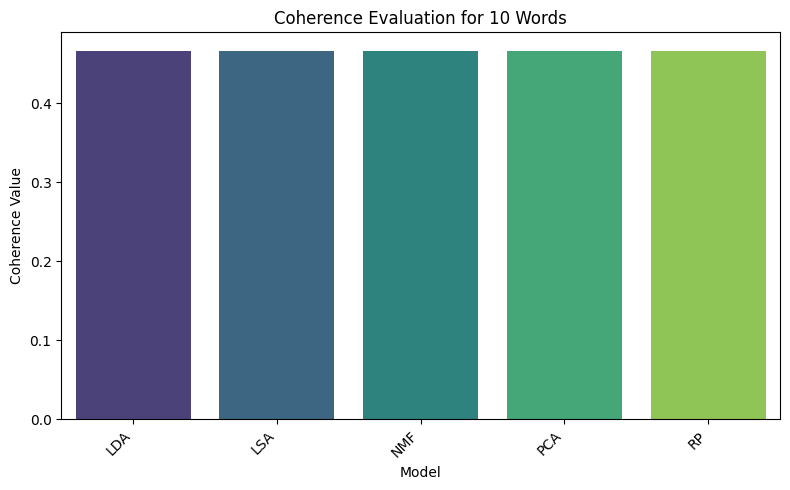

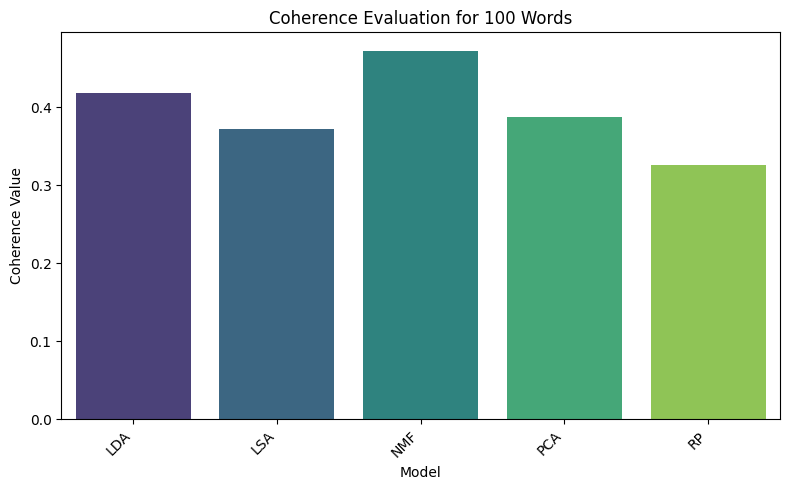

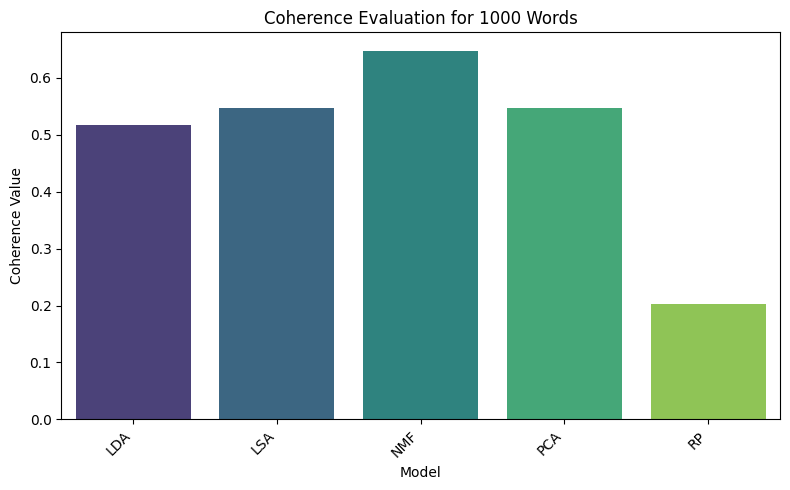

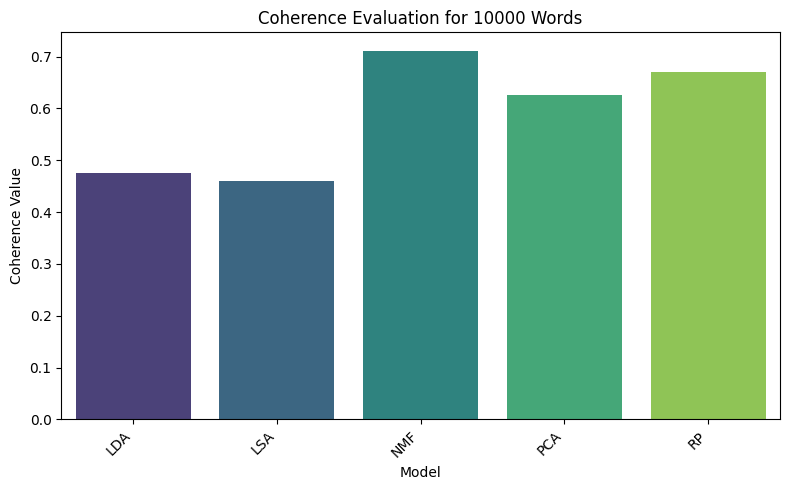

In [19]:
plots(evaluation_by_words, 'words')

Now we'll fit the LDA model with the number of topics that yields the highest coherence

In [11]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5,
                     alpha='symmetric', eta='auto', passes=5, random_state=1)

In [12]:
for topic in lda_model.print_topics(num_words=15):
    topic_index, words = topic
    word_list = [word.split("*")[1].strip().strip('"') for word in words.split(" + ")]
    print(f"Topic {topic_index}: {', '.join(word_list)}")

Topic 0: car, drive, bike, sale, buy, speed, sell, price, distribution, game, motorcycle, usa, scsi, power, work
Topic 1: window, file, email, system, key, program, chip, computer, help, phone, software, version, work, problem, card
Topic 2: god, christian, jesus, bible, christ, religion, morality, christianity, church, faith, objective, believe, sin, truth, belief
Topic 3: beast, anthony, walker, mask, amanda, duo, murphy, pt, intercon, hamburg, singapore, cs, alex, vesselin, stats
Topic 4: government, state, year, israel, israeli, armenian, law, writes, kill, world, gun, child, case, david, post


In [13]:
import pyLDAvis, pyLDAvis.gensim

In [14]:
# Visualize the LDA model using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='tsne')
pyLDAvis.display(vis)

Now we're going to do the same for LSA

In [15]:
lsi_model = LsiModel(corpus, id2word=dictionary, num_topics=5, random_seed = 1)

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\li

In [16]:
for topic in lsi_model.print_topics():
    topic_index, words = topic
    word_list = [word.split("*")[1].strip().strip('"') for word in words.split(" + ")]
    print(f"Topic {topic_index}: {', '.join(word_list)}")

Topic 0: system, work, window, god, problem, year, drive, distribution, file, computer
Topic 1: god, window, file, card, drive, christian, jesus, driver, program, believe
Topic 2: game, god, team, window, player, file, play, year, win, christian
Topic 3: key, chip, god, clipper, encryption, government, window, game, escrow, christian
Topic 4: drive, window, file, car, scsi, game, team, program, ide, key
